## **ONLINE stage**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import json

import sys
from fom import full_order_solution

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2959/3495357324.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2959/3495357324.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### MATRICES LOADING

In [2]:
# Apri il file in modalità lettura
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]   #N_epsilon x N_epsilon
    FF_RB = hf['FF_RB'][:]   #N_epsilon x 1
    KK_RB = hf['KK_RB'][:]   #N_D+N_D x N_epsilon x N_epsilon
    AA_RB = hf['AA_RB'][:]   #N_epsilon
    ZZ_CO = hf['ZZ_CO'][:]   #N_D
    II_CO = hf['II_CO'][:]   #N_D x N_D


### OF CASE

In [5]:
# Lettura dei parametri dal file JSON
with open("../0. full order/OF parameters.json", "r") as json_file:
    parameters = json.load(json_file)
T_BC = parameters["T_BC"]  
FISSION_RATE = parameters["FISSION_RATE"]                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 # [at/fiss]
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [ ]:
full_order_solution() 

#### SELECTION OF THE FULL ORDER PARAMETERS 

In [6]:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)


print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "fiss/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Fuel Thermal Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2000 K
The selected Fission Rate is 3e+19 fiss/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m
The selected Fission Yield is 0.24 at/fiss
The selected Fuel Thermal Conductivity k is 2.208 W/(m K)



#### CONSTRUCTION OF THE LHS AND RHS

In [7]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

#### FORWARD EULER

In [8]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1,1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

6.5401608302233205e+22
1.2768469559737866e+23
1.876501724900377e+23
2.457077899846546e+23
3.0211515013651166e+23
3.570531206330321e+23
4.106576089138546e+23
4.6303558233113135e+23
5.1427410022609675e+23
5.644458296098036e+23
6.136126289269918e+23
6.618279937026235e+23
7.091387919124261e+23
7.55586534590893e+23
8.012083303675983e+23
8.46037618163656e+23
8.90104740054936e+23
9.334373963942052e+23
9.760610125213688e+23
1.0179990379582954e+24
1.0592731932679273e+24
1.0999036757950698e+24
1.1399093327065515e+24
1.1793078077356957e+24
1.218115666566728e+24
1.2563485047067808e+24
1.294021040877237e+24
1.331147198336892e+24
1.367740176074258e+24
1.4038125114380247e+24
1.439376135486418e+24
1.474442422108637e+24
1.5090222317903453e+24
1.5431259507498268e+24
1.5767635260539056e+24
1.609944497227118e+24
1.6426780247892933e+24
1.6749729160921774e+24
1.7068376487722283e+24
1.7382803920921853e+24
1.76930902640666e+24
1.7999311609556307e+24
1.8301541501631774e+24
1.8599851085962667e+24
1.889430924719

#### COMPARISON WITH THE FULL ORDER MODEL

Errore massimo in python: 1.798E-03%
Errore massimo in sciantix: 1.789E-03%


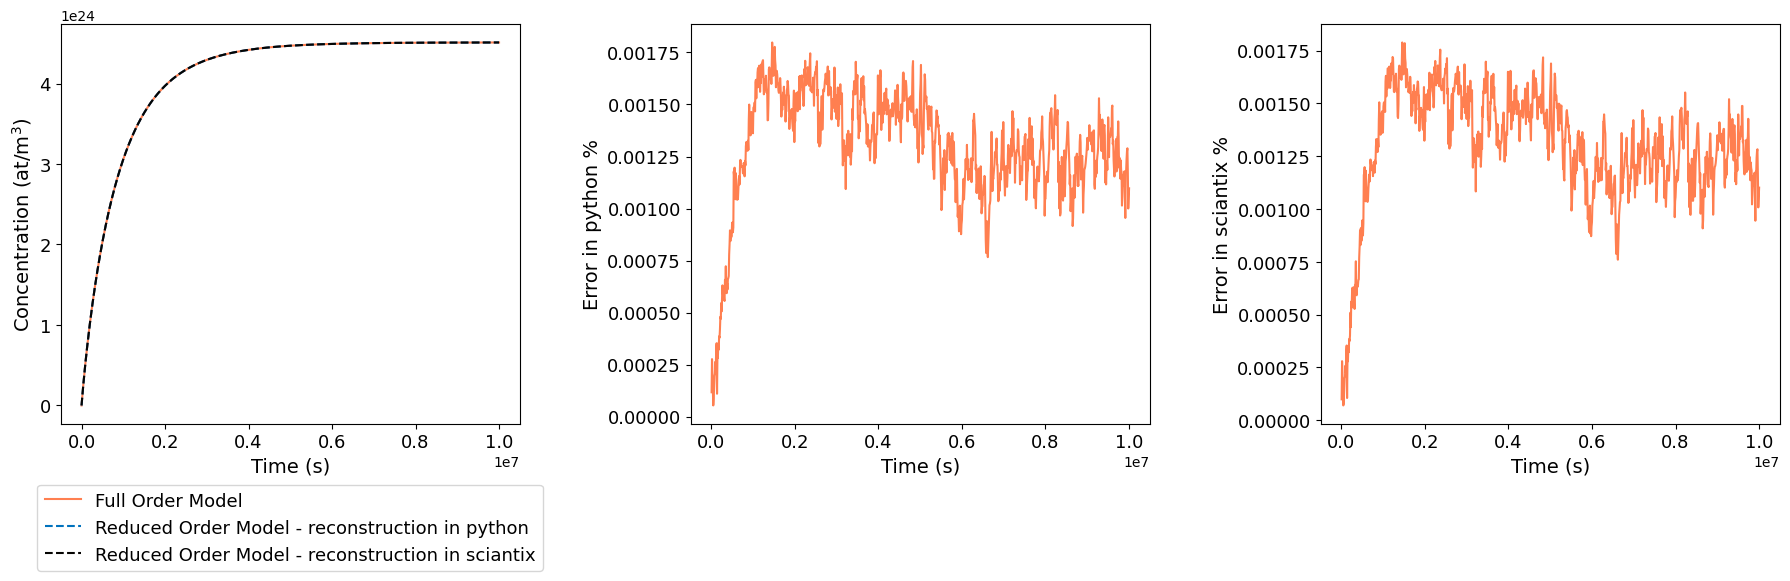

In [9]:
full_order= pd.read_csv('FOM_OF.csv')
sciantix =  pd.read_table("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/trial/reference case/output.txt")

#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in python: {error:.3E}%")
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - sciantix['Xe in grain (at/m3)'].iloc[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in sciantix: {error:.3E}%")

error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
error_python_max = np.max(error_python)
print(f"Errore massimo in python: {error_python_max:.3E}%")

error_sciantix = (np.abs(full_order.iloc[:, 1] - sciantix['Xe in grain (at/m3)']) / full_order.iloc[:, 1]) * 100
error_sciantix_max = np.max(error_sciantix)
print(f"Errore massimo in sciantix: {error_sciantix_max:.3E}%")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(np.linspace(0, 1e7, 1001), full_order.iloc[:, 1], label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),sciantix['Xe in grain (at/m3)'], '--', label='Reduced Order Model - reconstruction in sciantix', color='#050402', linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Time (s)',fontsize=14)
ax2.set_ylabel('Error in python %',fontsize=14)

ax3.plot(np.linspace(0, 1e7, 1001), error_sciantix, color='#FF7F50', linewidth=1.5)
ax3.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis='x', labelsize=13)
ax3.ticklabel_format(useOffset=False)
ax3.set_xlabel('Time (s)',fontsize=14)
ax3.set_ylabel('Error in sciantix %',fontsize=14)

plt.tight_layout()

### WORST RECONSTRUCTED PARAMETERS CASE

In [3]:
# Lettura dei parametri dal file JSON
with open("../2. DEIM-POD/data/worst reconstructed parameters.json", "r") as json_file:
    parameters = json.load(json_file)

T_BC = parameters["T_BC"]  
FISSION_RATE = parameters["FISSION_RATE"]                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 # [at/fiss]
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [4]:
full_order_solution(RADIUS=RADIUS, LENGTH=LENGTH, FISSION_RATE=FISSION_RATE, FISSION_YIELD=FISSION_YIELD, T_BC=T_BC, FUEL_THERMAL_CONDUCTIVITY=FUEL_THERMAL_CONDUCTIVITY, TIME_FINAL = TIME_FINAL, TIME_DELTA = TIME_DELTA)

Current time: 0.0 s
Average dC: 0.0 atm/m^3

Current time: 10000.0 s
Average dC: 5.707794959824484e+22 atm/m^3

Current time: 20000.0 s
Average dC: 1.1306561567294877e+23 atm/m^3

Current time: 30000.0 s
Average dC: 1.6821643577668376e+23 atm/m^3

Current time: 40000.0 s
Average dC: 2.2266729061009314e+23 atm/m^3

Current time: 50000.0 s
Average dC: 2.7650603966478315e+23 atm/m^3

Current time: 60000.0 s
Average dC: 3.297949458723167e+23 atm/m^3

Current time: 70000.0 s
Average dC: 3.8258103460608815e+23 atm/m^3

Current time: 80000.0 s
Average dC: 4.349014484154128e+23 atm/m^3

Current time: 90000.0 s
Average dC: 4.867864702011985e+23 atm/m^3

Current time: 100000.0 s
Average dC: 5.382613603214835e+23 atm/m^3

Current time: 110000.0 s
Average dC: 5.8934762808993585e+23 atm/m^3

Current time: 120000.0 s
Average dC: 6.400639652625716e+23 atm/m^3

Current time: 130000.0 s
Average dC: 6.904266514552104e+23 atm/m^3

Current time: 140000.0 s
Average dC: 7.404501192386436e+23 atm/m^3

Curren

In [5]:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "fiss/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Fuel Thermal Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 1754.9735337233922 K
The selected Fission Rate is 2.179168538261009e+19 fiss/s
The selected Grain Length is 0.001202512130153599 m
The selected Grain Radius is 1.2466827023386472e-05 m
The selected Fission Yield is 0.27344075082791025 at/fiss
The selected Fuel Thermal Conductivity k is 2.408637553430885 W/(m K)



In [6]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [7]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1,1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

5.707066759309318e+22
1.1306368897402341e+23
1.6821574318225314e+23
2.226665680612964e+23
2.765058349333892e+23
3.2979597245333184e+23
3.825835738610692e+23
4.3490531739220384e+23
4.8679120026760376e+23
5.3826642073030416e+23
5.893525526244787e+23
6.400683301020851e+23
6.904302036255373e+23
7.404527524806084e+23
7.901490013111883e+23
8.395306688686971e+23
8.886083668313722e+23
9.3739176070617e+23
9.858897013121022e+23
1.0341103330926519e+24
1.0820611839781359e+24
1.1297492404342426e+24
1.177181010535073e+24
1.224362577297437e+24
1.2712996440517057e+24
1.317997573266345e+24
1.3644614199630047e+24
1.4106959606382425e+24
1.456705718433334e+24
1.5024949851547592e+24
1.548067840637293e+24
1.5934281698529767e+24
1.6385796780980852e+24
1.6835259045328506e+24
1.7282702343022948e+24
1.7728159094288258e+24
1.8171660386366068e+24
1.8613236062425443e+24
1.9052914802281355e+24
1.9490724195893855e+24
1.9926690810479163e+24
2.0360840251946806e+24
2.0793197221278544e+24
2.1223785566382914e+24
2.165262

Errore massimo in python: 1.276E-02%
Errore massimo in sciantix: 9.702E+01%


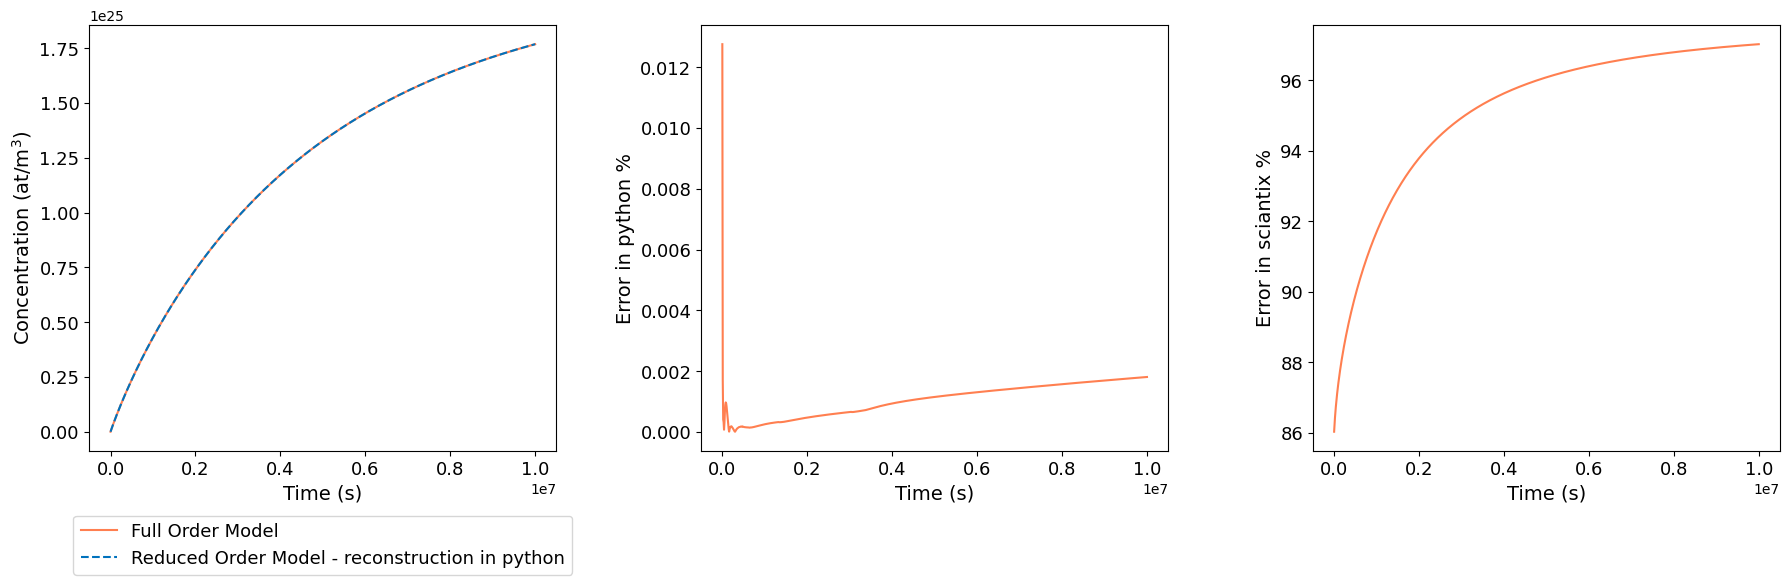

In [9]:
full_order= pd.read_csv('FOM.csv')
sciantix =  pd.read_table("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/trial/worst reconstructed parameters case/output.txt")
 
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in python: {error:.3E}%")
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - sciantix['Xe in grain (at/m3)'].iloc[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in sciantix: {error:.3E}%")

error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
error_python_max = np.max(error_python)
print(f"Errore massimo in python: {error_python_max:.3E}%")

error_sciantix = (np.abs(full_order.iloc[:, 1] - sciantix['Xe in grain (at/m3)']) / full_order.iloc[:, 1]) * 100
error_sciantix_max = np.max(error_sciantix)
print(f"Errore massimo in sciantix: {error_sciantix_max:.3E}%")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(np.linspace(0, 1e7, 1001), full_order.iloc[:, 1], label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)
#ax1.plot(np.linspace(0, 1e7, 1001),sciantix['Xe in grain (at/m3)'], '--', label='Reduced Order Model - reconstruction in sciantix', color='#050402', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Time (s)',fontsize=14)
ax2.set_ylabel('Error in python %',fontsize=14)

ax3.plot(np.linspace(0, 1e7, 1001), error_sciantix, color='#FF7F50', linewidth=1.5)
ax3.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis='x', labelsize=13)
ax3.ticklabel_format(useOffset=False)
ax3.set_xlabel('Time (s)',fontsize=14)
ax3.set_ylabel('Error in sciantix %',fontsize=14)

plt.tight_layout()

### Out of range

In [85]:
T_BC = 2600 
FISSION_RATE = 6e19                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = 1                 # [at/fiss]
FUEL_DENSITY = parameters["FUEL_DENSITY"]                   # [kg/m^3]
FUEL_SPECIFIC_HEAT = parameters["FUEL_SPECIFIC_HEAT"]       # [J/(kg K)]
FUEL_THERMAL_CONDUCTIVITY = 10  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [86]:
full_order_solution(RADIUS=RADIUS, LENGTH=LENGTH, FISSION_RATE=FISSION_RATE, FISSION_YIELD=FISSION_YIELD, FUEL_DENSITY=FUEL_DENSITY, FUEL_SPECIFIC_HEAT=FUEL_SPECIFIC_HEAT, T_BC=T_BC, FUEL_THERMAL_CONDUCTIVITY=FUEL_THERMAL_CONDUCTIVITY, TIME_FINAL = TIME_FINAL, TIME_DELTA = TIME_DELTA)

Current time: 0.0 s
Average dC: 0.0 atm/m^3

Current time: 10000.0 s
Average dC: 4.6853197348316544e+23 atm/m^3

Current time: 20000.0 s
Average dC: 8.760845498073556e+23 atm/m^3

Current time: 30000.0 s
Average dC: 1.2400912231779743e+24 atm/m^3

Current time: 40000.0 s
Average dC: 1.5693654148937845e+24 atm/m^3

Current time: 50000.0 s
Average dC: 1.8694638408923294e+24 atm/m^3

Current time: 60000.0 s
Average dC: 2.144317773122208e+24 atm/m^3

Current time: 70000.0 s
Average dC: 2.3969075892991483e+24 atm/m^3

Current time: 80000.0 s
Average dC: 2.6296037889813706e+24 atm/m^3

Current time: 90000.0 s
Average dC: 2.8443603553099764e+24 atm/m^3

Current time: 100000.0 s
Average dC: 3.0428257019823973e+24 atm/m^3

Current time: 110000.0 s
Average dC: 3.2264244031526284e+24 atm/m^3

Current time: 120000.0 s
Average dC: 3.396402061666728e+24 atm/m^3

Current time: 130000.0 s
Average dC: 3.5538694174251023e+24 atm/m^3

Current time: 140000.0 s
Average dC: 3.699807111694458e+24 atm/m^3

Cu

In [87]:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
POWER_DENSITY = FISSION_ENERGY * FISSION_RATE   #q''' [W/m^3]
FISSION_HEAT = FISSION_ENERGY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)    #[K/fissions] = Energia di fissione/(rho Cp)
SOURCE_T = POWER_DENSITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)   #[K/s] = q'''/(rho Cp) 
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
ALPHA_T = FUEL_THERMAL_CONDUCTIVITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)  # [m^2 / s]        # = k/(rho Cp)

print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "fiss/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Fuel Thermal Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2600 K
The selected Fission Rate is 6e+19 fiss/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m
The selected Fission Yield is 1 at/fiss
The selected Fuel Thermal Conductivity k is 10 W/(m K)



In [ ]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [89]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1,1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

4.946414537427044e+22
5.498588016577226e+22
5.563717787082717e+22
5.571618885425682e+22
5.572599478201938e+22
5.572723721639281e+22
5.572739764010405e+22
5.572741870937966e+22
5.572742151841273e+22
5.57274218978523e+22
5.5727421949685824e+22
5.5727421956834806e+22
5.5727421957828856e+22
5.5727421957968065e+22
5.572742195798762e+22
5.57274219579904e+22
5.572742195799079e+22
5.572742195799084e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742

Errore massimo in python: 9.900E+01%


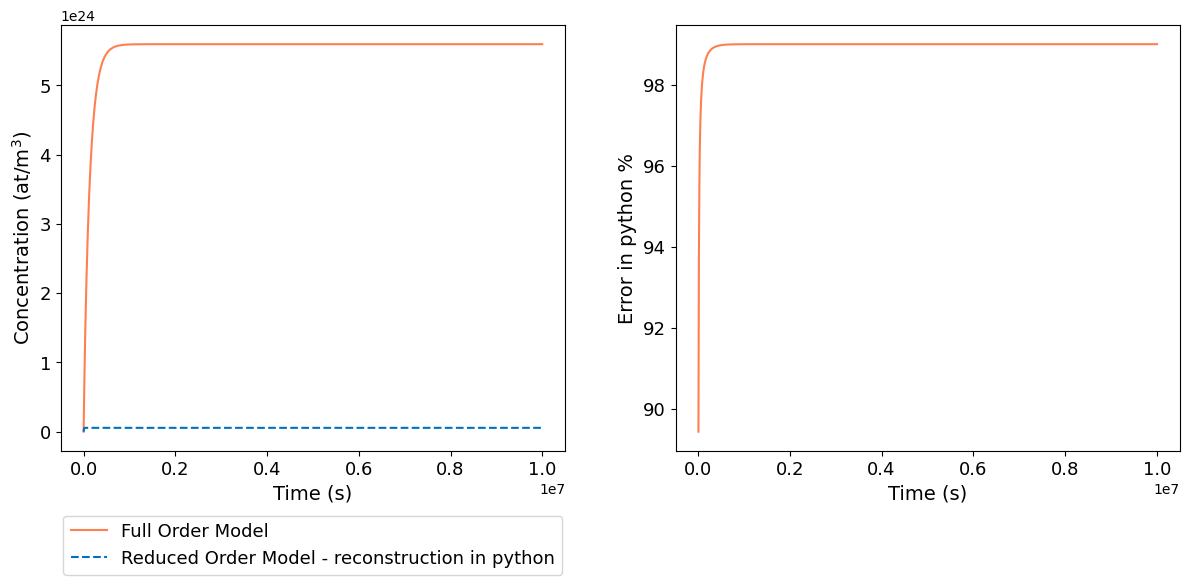

In [90]:
full_order= pd.read_csv('FOM.csv')

error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
error_python_max = np.max(error_python)
print(f"Errore massimo in python: {error_python_max:.3E}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(np.linspace(0, 1e7, 1001), full_order.iloc[:, 1], label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Time (s)',fontsize=14)
ax2.set_ylabel('Error in python %',fontsize=14)

plt.tight_layout()